# PCA (Principal Component Analysis)
In the first step, I load bo the clinical metadata, the collapsed dataset (that was not zscored), and the z-scored dataset.

In [77]:
import os
import pandas as pd
from pathlib import Path
from dotenv import load_dotenv
from sklearn.decomposition import PCA
import umap
import matplotlib.pyplot as plt
import seaborn as sns

# Load environment variables and find repo root
load_dotenv(dotenv_path="/Users/sarah/Code/bioinformatics-tool/analysis/.env")

def find_repo_root(start_path: Path = None) -> Path:
    if start_path is None:
        start_path = Path().resolve()
    for parent in [start_path] + list(start_path.parents):
        if (parent / '.git').exists():
            return parent
    raise RuntimeError("Could not find repo root!")

repo_root = find_repo_root()

# Load clinical data
clinical_path = repo_root / os.getenv("CLINICAL")
clinical_df = pd.read_csv(clinical_path, index_col=0)

# Load expression (z-scored) data
zscored_path = repo_root / os.getenv("ZSCORED_QUALITY_CHECKED")
zscored_df = pd.read_csv(zscored_path, index_col=0)

# Make sure both dataframes have the same samples and are in the same order
common_samples = clinical_df.index.intersection(zscored_df.index)
clinical_df = clinical_df.loc[common_samples]
zscored_df = zscored_df.loc[common_samples]


collapsed_path = repo_root / os.getenv("EM_COLLAPSED")
collapsed_df = pd.read_csv(collapsed_path, index_col=0)

common_samples = clinical_df.index.intersection(collapsed_df.index)
clinical_df = clinical_df.loc[common_samples]
collapsed_df = collapsed_df.loc[common_samples]

print(f"Zscored data shape: {zscored_df.shape}")
print(f"Collapsed (not zscored) data shape: {collapsed_df.shape}")
print(f"Clinical data shape: {clinical_df.shape}")

Zscored data shape: (3273, 26150)
Collapsed (not zscored) data shape: (3273, 26150)
Clinical data shape: (3273, 34)


## Z-Scored

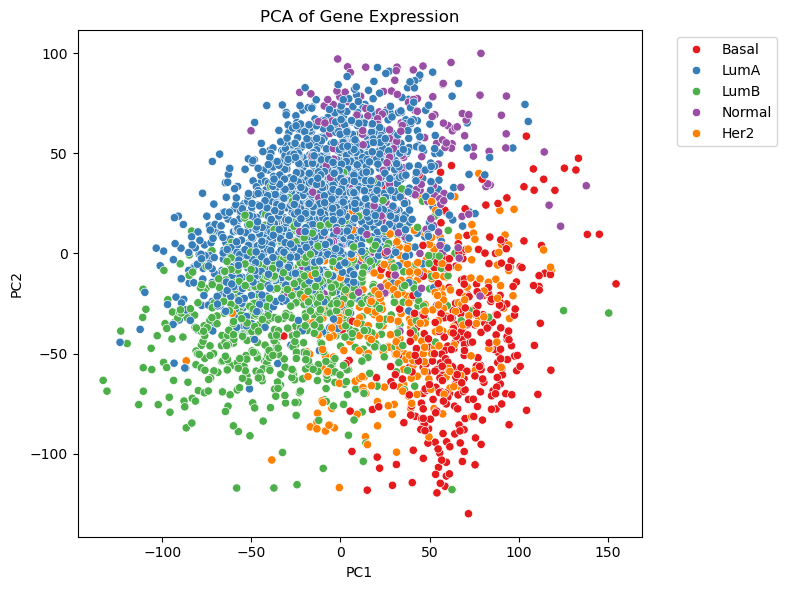

In [78]:
# --- PCA ---
pca = PCA(n_components=2)
pca_result = pca.fit_transform(zscored_df.values)

pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'], index=zscored_df.index)
pca_df = pca_df.join(clinical_df)

plt.figure(figsize=(8,6))
sns.scatterplot(
    x='PC1', y='PC2', 
    data=pca_df, 
    hue='OG_pam50 subtype',    
    palette='Set1'
)
plt.title('PCA of Gene Expression')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [79]:
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import LabelEncoder

# For PCA: explained variance
print(f"Explained variance by PC1: {pca.explained_variance_ratio_[0]:.2%}")
print(f"Explained variance by PC2: {pca.explained_variance_ratio_[1]:.2%}")
print(f"Total variance explained by PC1 and PC2: {pca.explained_variance_ratio_[:2].sum():.2%}")

# For silhouette score, only works if you have group labels (e.g., 'subtype')
label_col = 'OG_pam50 subtype'  
if label_col in clinical_df.columns:
    # Encode labels to integers
    labels = LabelEncoder().fit_transform(clinical_df[label_col].astype(str))
    # Silhouette for PCA embedding
    sil_pca = silhouette_score(pca_result, labels)
    print(f"PCA Silhouette Score (w.r.t {label_col}): {sil_pca:.3f}")
else:
    print(f"No '{label_col}' column found in clinical data; skipping silhouette score.")


Explained variance by PC1: 7.55%
Explained variance by PC2: 6.41%
Total variance explained by PC1 and PC2: 13.97%
PCA Silhouette Score (w.r.t OG_pam50 subtype): 0.061


In [80]:
from scipy.stats import f_oneway, kruskal

# Example for PC1 by group
groups = [pca_df['PC1'][pca_df[label_col] == g].values for g in pca_df[label_col].unique()]
anova_p = f_oneway(*groups).pvalue
print(f"ANOVA p-value for PC1 between {label_col} groups: {anova_p:.3e}")


ANOVA p-value for PC1 between OG_pam50 subtype groups: 0.000e+00


### Subsetting

In [81]:
N = 8000
gene_variances = zscored_df.var(axis=0)
top_genes = gene_variances.sort_values(ascending=False).head(N).index
zscored_top = zscored_df[top_genes]

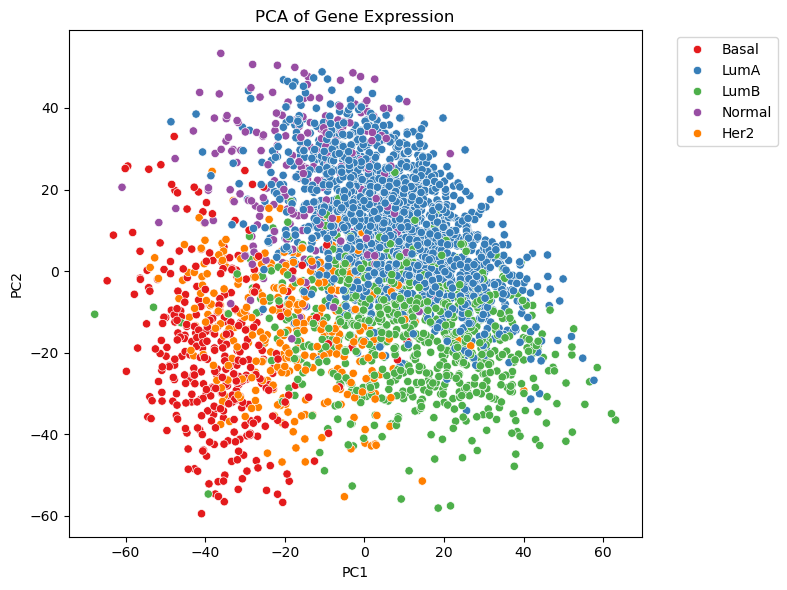

In [82]:
# --- PCA ---
pca = PCA(n_components=2)
pca_result = pca.fit_transform(zscored_top.values)

pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'], index=zscored_top.index)
pca_df = pca_df.join(clinical_df)

plt.figure(figsize=(8,6))
sns.scatterplot(
    x='PC1', y='PC2', 
    data=pca_df, 
    hue='OG_pam50 subtype',    
    palette='Set1'
)
plt.title('PCA of Gene Expression')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


F842     72.939587
F1653    72.184324
F2858    71.266590
F1063    68.579149
F1299    67.263665
F2815    66.591775
F3213    66.307059
F286     66.244398
F2461    65.694684
F3085    65.608209
dtype: float64


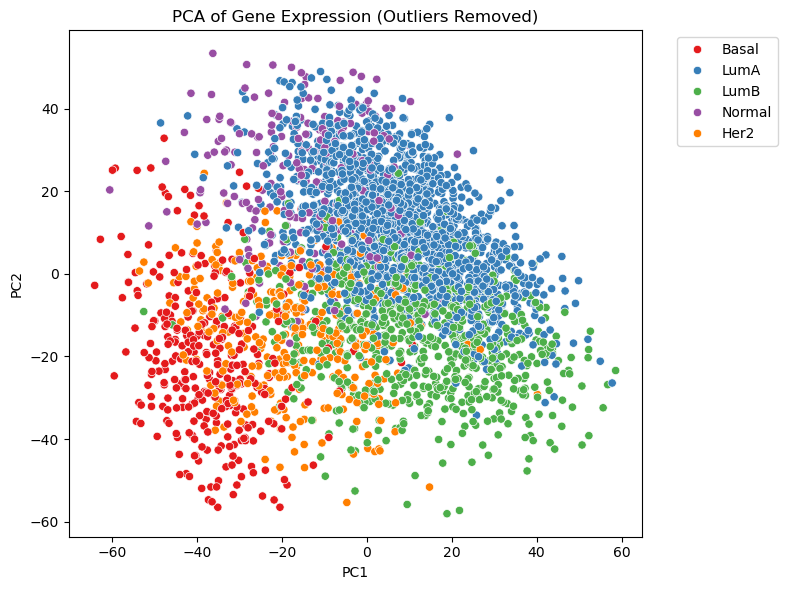

In [83]:
import numpy as np

# Your pca_df contains PC1 and PC2 columns
# Calculate the "distance from center" for each sample
distances = np.sqrt(pca_df['PC1']**2 + pca_df['PC2']**2)

# Look at the distances to find a sensible threshold
print(distances.sort_values(ascending=False).head(10))

# Set a threshold (e.g., 3 standard deviations from mean)
threshold = distances.mean() + 3 * distances.std()
outliers = distances > threshold

# Remove outliers
pca_df_no_outliers = pca_df[~outliers]
filtered_df_no_outliers = zscored_top.loc[pca_df_no_outliers.index]  # Keep only samples left

# Re-run PCA with outliers removed
pca = PCA(n_components=2)
pca_result = pca.fit_transform(filtered_df_no_outliers.values)
pca_df_final = pd.DataFrame(pca_result, columns=['PC1', 'PC2'], index=filtered_df_no_outliers.index)
pca_df_final = pca_df_final.join(clinical_df)

# Plot again
plt.figure(figsize=(8,6))
sns.scatterplot(
    x='PC1', y='PC2', 
    data=pca_df_final, 
    hue='OG_pam50 subtype',    
    palette='Set1'
)
plt.title('PCA of Gene Expression (Outliers Removed)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [85]:
from scipy.stats import f_oneway, kruskal

# Example for PC1 by group
groups = [pca_df['PC1'][pca_df[label_col] == g].values for g in pca_df[label_col].unique()]
anova_p = f_oneway(*groups).pvalue
print(f"ANOVA p-value for PC1 between {label_col} groups: {anova_p:.3e}")


ANOVA p-value for PC1 between OG_pam50 subtype groups: 0.000e+00


## Collapsed

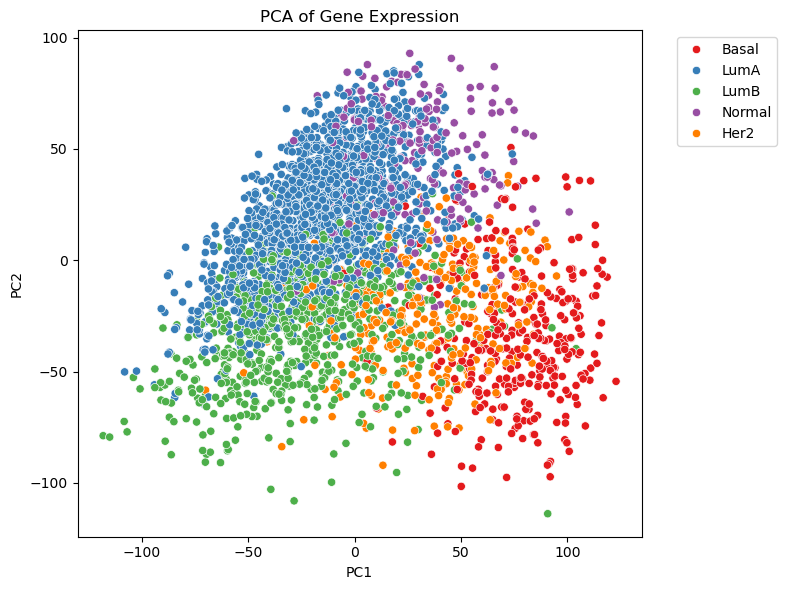

In [86]:
# --- PCA ---
pca = PCA(n_components=2)
pca_result = pca.fit_transform(collapsed_df.values)

pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'], index=collapsed_df.index)
pca_df = pca_df.join(clinical_df)

plt.figure(figsize=(8,6))
sns.scatterplot(
    x='PC1', y='PC2', 
    data=pca_df, 
    hue='OG_pam50 subtype',    
    palette='Set1'
)
plt.title('PCA of Gene Expression')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [87]:
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import LabelEncoder

# For PCA: explained variance
print(f"Explained variance by PC1: {pca.explained_variance_ratio_[0]:.2%}")
print(f"Explained variance by PC2: {pca.explained_variance_ratio_[1]:.2%}")
print(f"Total variance explained by PC1 and PC2: {pca.explained_variance_ratio_[:2].sum():.2%}")

# For silhouette score, only works if you have group labels (e.g., 'subtype')
label_col = 'OG_pam50 subtype' 
if label_col in clinical_df.columns:
    # Encode labels to integers
    labels = LabelEncoder().fit_transform(clinical_df[label_col].astype(str))
    # Silhouette for PCA embedding
    sil_pca = silhouette_score(pca_result, labels)
    print(f"PCA Silhouette Score (w.r.t {label_col}): {sil_pca:.3f}")
else:
    print(f"No '{label_col}' column found in clinical data; skipping silhouette score.")


Explained variance by PC1: 7.11%
Explained variance by PC2: 5.54%
Total variance explained by PC1 and PC2: 12.65%
PCA Silhouette Score (w.r.t OG_pam50 subtype): 0.095


In [88]:
from scipy.stats import f_oneway, kruskal

# Example for PC1 by group
groups = [pca_df['PC1'][pca_df[label_col] == g].values for g in pca_df[label_col].unique()]
anova_p = f_oneway(*groups).pvalue
print(f"ANOVA p-value for PC1 between {label_col} groups: {anova_p:.3e}")

ANOVA p-value for PC1 between OG_pam50 subtype groups: 0.000e+00
